# EDA

* Import and load files for stage 1 
* Variants data 
    + Base table look
    + Visulisation of Gene and Variation Data
    + Class Balance
    + Gene Data Exploration
    + Variation Data Exploration
* Text data
    + Overview
    + On data cleaning and preparations
    + Length Feature
    + Density
* Load and visualise stage 2 data

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## load data

In [219]:
train_variants = pd.read_csv("data/training_variants")
test_variants = pd.read_csv("data/test_variants")

train_text = pd.read_csv("data/training_text", sep="\|\|", engine='python', header=None, skiprows=1,names=["id","text"])
test_text = pd.read_csv("data/test_text", sep="\|\|", engine='python', header=None, skiprows=1,names=["id","text"])

In [220]:
print("Train variants\t",train_variants.shape)
print("Test variants\t",test_variants.shape)
print("Train text\t", train_text.shape)
print("Test text\t", test_text.shape)

Train variants	 (3321, 4)
Test variants	 (5668, 3)
Train text	 (3321, 2)
Test text	 (5668, 2)


## Training Variants

In [221]:
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


## Preliminary look at Gene data

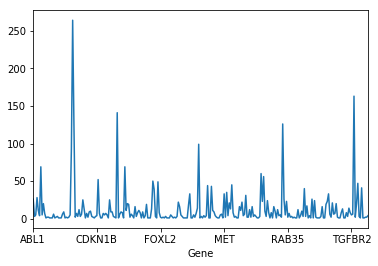

In [222]:
train_variants.groupby('Gene')['Gene'].count().plot()

## Preliminary look at Variation data

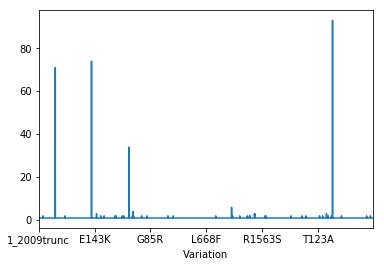

In [223]:
train_variants.groupby('Variation')['Variation'].count().plot()

comment: _needs further analysis for usefulness of feature_

## Class Balance

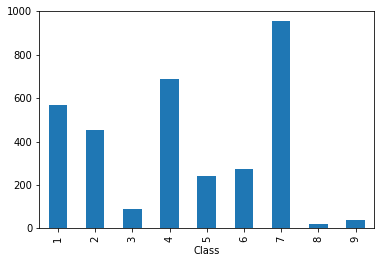

In [224]:
train_variants.groupby('Class')['Class'].count().plot(kind='bar')

#### Seems to be very imbalanced. Ways to tackle would be to Oversample for minority classes. Something like [SMOTE](https://arxiv.org/abs/1106.1813) should work.


## Gene Data

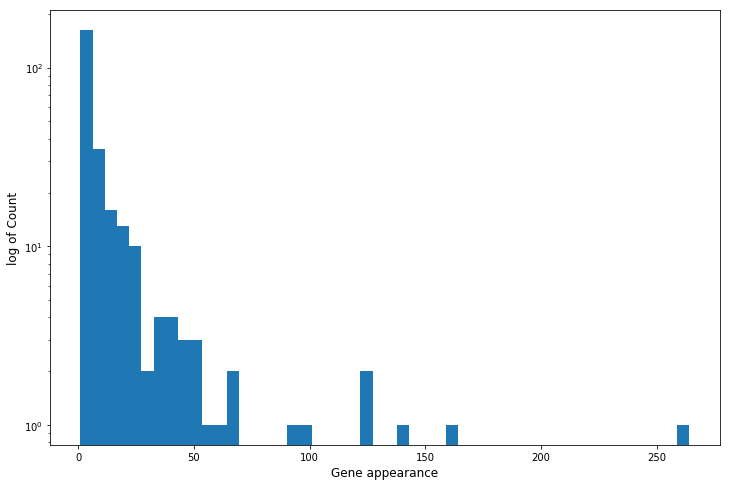

In [225]:
train_genes = train_variants.groupby('Gene')['Gene'].count()
plt.figure(figsize=(12,8))
plt.hist(train_genes.values,bins=50,log=True)
plt.xlabel('Gene appearance', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()

In [226]:
print(train_genes.count(),'\n','Percent less than:')
for i in [10,20,30,40,50,60,80,100,150,200,250]:
    print(i,"\t:\t",round((train_genes<i).mean()*100,2),'%')

264 
 Percent less than:
10 	:	 71.59 %
20 	:	 82.95 %
30 	:	 90.15 %
40 	:	 92.42 %
50 	:	 95.08 %
60 	:	 96.21 %
80 	:	 97.35 %
100 	:	 98.11 %
150 	:	 99.24 %
200 	:	 99.62 %
250 	:	 99.62 %


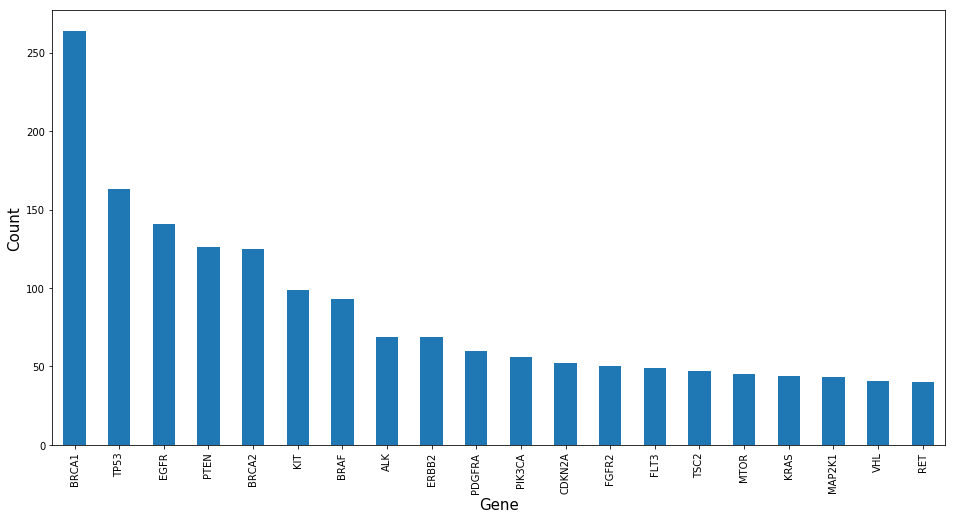

In [227]:
plt.figure(figsize=(16,8))
ax = train_variants['Gene'].value_counts()[:20].plot.bar()
ax.set_xlabel("Gene",size=15)
ax.set_ylabel("Count",size=15)
plt.show()

## Variation Data

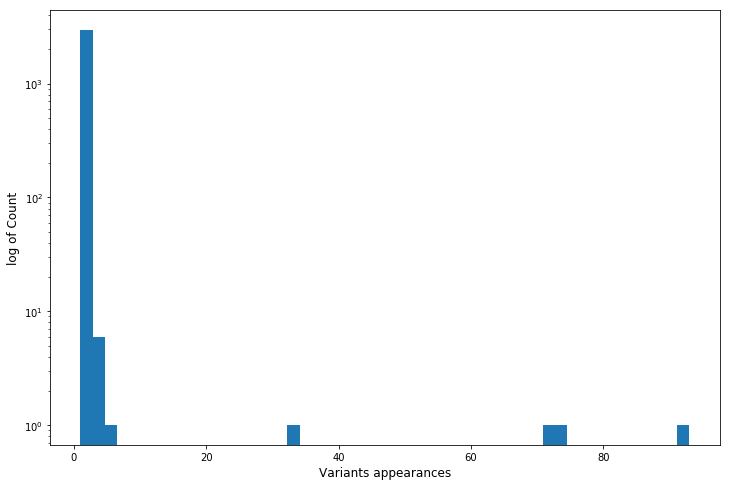

In [228]:
train_variations = train_variants.groupby('Variation')['Variation'].count()
#print(train_variations)
plt.figure(figsize=(12,8))
plt.hist(train_variations.values,bins=50,log=True)
plt.xlabel('Variants appearances', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()

In [229]:
print(train_variations.count(),"|Count less than 2: ",int((train_variations<2).mean()*train_variations.count()))

2996 |Count less than 2:  2946


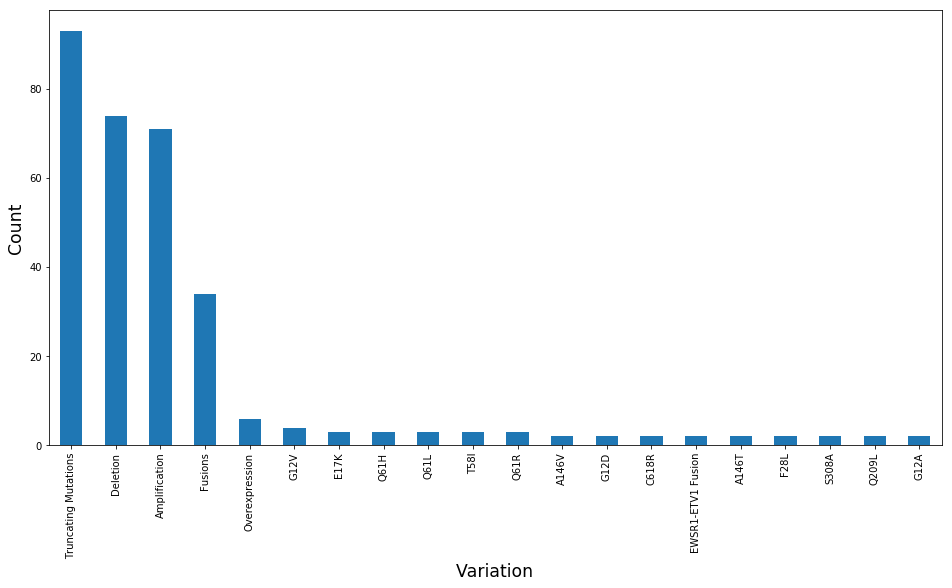

In [230]:
plt.figure(figsize=(16,8))
ax = train_variants['Variation'].value_counts()[:20].plot.bar()
ax.set_xlabel("Variation", size='xx-large')
ax.set_ylabel("Count", size='xx-large')
plt.show()

## Medical Text

In [231]:
train_text.head()

,id,text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Overview

In [232]:
print("2000 out of",len(train_text['text'][0]),":\n",train_text['text'][0][:2000])

2000 out of 39672 :
 Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silenc

Will need a lot of preprocessing. Thoughts: 
- Use of genomic dataset for vectorisation would yield better results.
- Lots of Domain specific information in the text
- Analysis of graphs showing number of tokens in dataset to select correct number of vectors is essential
    - Problem with Training time (depending on model) and Memory requirement anticipated
    - n-grams will be slow but crucial. probably ngram(1,2) is feasible right now (3+ to be experimented)
    - [Vectorizing with hashing](http://scikit-learn.org/stable/modules/feature_extraction.html#vectorizing-a-large-text-corpus-with-the-hashing-trick)
- Custom Stop words?

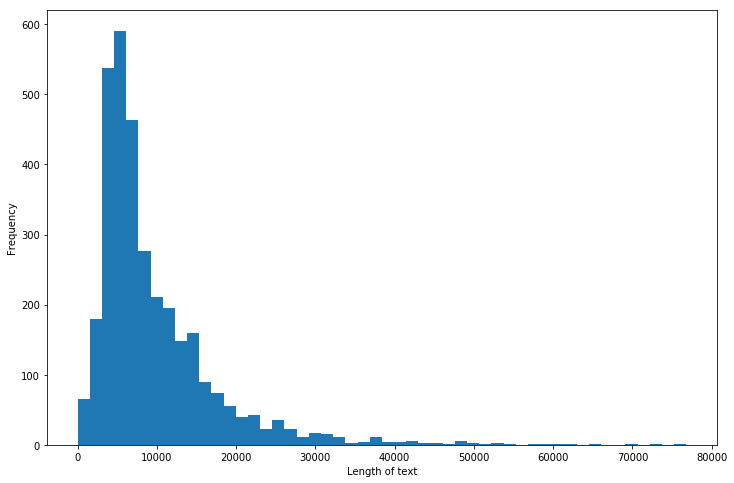

In [233]:
train_text['len'] = train_text['text'].apply(lambda x : len(x.split()))
plt.figure(figsize=(12,8))
train_text['len'].plot.hist(bins=50)
plt.xlabel('Length of text')
plt.show()

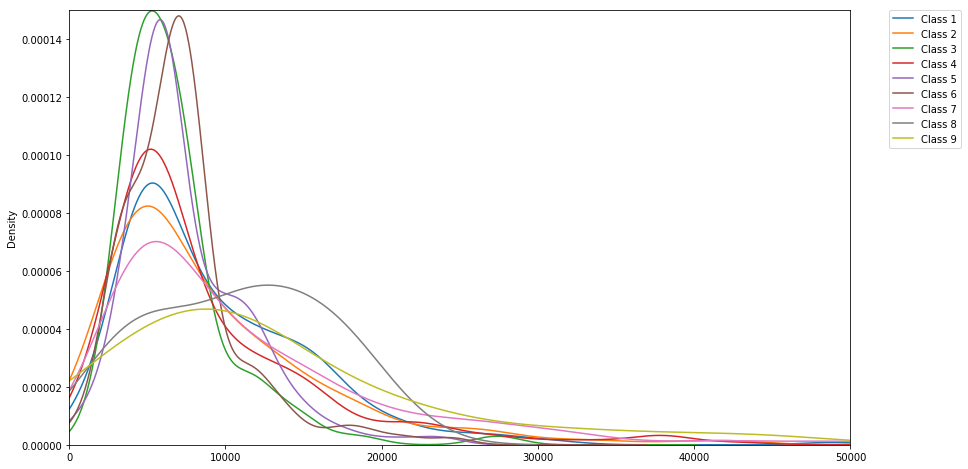

In [234]:
plt.figure(figsize=(14,8))
for i in range(9):
    ax = train_text['len'][train_variants[train_variants['Class']==(i+1)].index].plot(kind='kde',label='Class '+str(i+1))
ax.set_ylim(0,0.00015)
ax.set_xlim(0,50000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Stage 2 Data

In [235]:
df_variants_train = pd.read_csv('data/training_variants', usecols=['Gene', 'Variation', 'Class'])
df_text_train = pd.read_csv('data/training_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
df_variants_train['Text'] = df_text_train['Text']
train = df_variants_train

In [236]:
df_variants_test = pd.read_csv('data/test_variants', usecols=['ID', 'Gene', 'Variation'])
df_text_test = pd.read_csv('data/test_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
df_variants_test['Text'] = df_text_test['Text']
test = df_variants_test

In [237]:
# read stage1 solutions
df_labels_test = pd.read_csv('data/stage1_solution_filtered.csv')
df_labels_test['Class'] = pd.to_numeric(df_labels_test.drop('ID', axis=1).idxmax(axis=1).str[5:])

# join with test_data on same indexes
test = test.merge(df_labels_test[['ID', 'Class']], on='ID', how='left').drop('ID', axis=1)
test = test[test['Class'].notnull()]

# join train and test files
stage_2_train = pd.concat([train, test])

In [238]:
stage_2_train.reset_index(drop=True, inplace=True)

In [239]:
stage_2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3689 entries, 0 to 3688
Data columns (total 4 columns):
Class        3689 non-null float64
Gene         3689 non-null object
Text         3689 non-null object
Variation    3689 non-null object
dtypes: float64(1), object(3)
memory usage: 115.4+ KB


In [240]:
pd.concat([df_test['Class'].value_counts(), stage_2_train['Class'].value_counts()], axis=1, keys=['Test', 'All'])

,Test,All
1.0,94,662
2.0,46,498
3.0,7,96
4.0,65,751
5.0,25,267
6.0,22,297
7.0,101,1054
8.0,2,21
9.0,6,43


In [241]:
stage_2_train

,Class,Gene,Text,Variation
0,1.0,FAM58A,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations
1,2.0,CBL,Abstract Background Non-small cell lung canc...,W802*
2,2.0,CBL,Abstract Background Non-small cell lung canc...,Q249E
3,3.0,CBL,Recent evidence has demonstrated that acquired...,N454D
4,4.0,CBL,Oncogenic mutations in the monomeric Casitas B...,L399V
5,4.0,CBL,Oncogenic mutations in the monomeric Casitas B...,V391I
6,5.0,CBL,Oncogenic mutations in the monomeric Casitas B...,V430M
7,1.0,CBL,CBL is a negative regulator of activated recep...,Deletion
8,4.0,CBL,Abstract Juvenile myelomonocytic leukemia (JM...,Y371H
9,4.0,CBL,Abstract Juvenile myelomonocytic leukemia (JM...,C384R


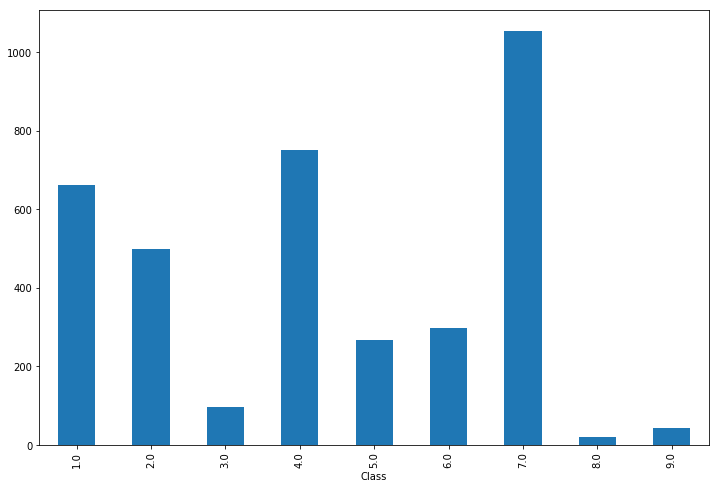

In [242]:
plt.figure(figsize=(12,8))
stage_2_train.groupby('Class')['Class'].count().plot(kind='bar')